[![Fixel Algorithms](https://i.imgur.com/AqKHVZ0.png)](https://fixelalgorithms.gitlab.io/)

#  Transfer Learning of resnet

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 29/05/2024 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0093DeepLearningTransferLearning.ipynb)

In [1]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterGrid

# Deep Learning
import torch
import torch.nn            as nn
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import LRScheduler
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchinfo
from torchmetrics.classification import MulticlassAccuracy
import torchvision
from torchvision.transforms import v2 as TorchVisionTrns

# Miscellaneous
import copy
from enum import auto, Enum, unique
import math
import os
from platform import python_version
import random
import shutil
import time

# Typing
from typing import Callable, Dict, Generator, List, Optional, Self, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import HTML, Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

2024-06-14 01:49:13.932980: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [2]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())

# Improve performance by benchmarking
torch.backends.cudnn.benchmark = True

# Reproducibility (Per PyTorch Version on the same device)
# torch.manual_seed(seedNum)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark     = False #<! Makes things slower


In [3]:
# Constants

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('b', 'r')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2

DATA_SET_FILE_NAME      = 'archive.zip'
DATA_SET_FOLDER_NAME    = 'IntelImgCls'

D_CLASSES  = {0: 'Buildings', 1: 'Forest', 2: 'Glacier', 3: 'Mountain', 4: 'Sea', 5: 'Street'}
L_CLASSES  = ['Buildings', 'Forest', 'Glacier', 'Mountain', 'Sea', 'Street']
T_IMG_SIZE = (150, 150, 3)

DATA_FOLDER_PATH    = 'Data'
TENSOR_BOARD_BASE   = 'TB'


In [4]:
# Download Auxiliary Modules for Google Colab
if runInGoogleColab:
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DataManipulation.py
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DataVisualization.py
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DeepLearningPyTorch.py

In [5]:
# Courses Packages
import sys
sys.path.append('/home/vlad/utils')
from DataVisualization import PlotLabelsHistogram
from DeepLearningPyTorch import TBLogger, TestDataSet
from DeepLearningPyTorch import TrainModel, TrainModelSch


* <font color='blue'>(**!**)</font> Go through `TestDataSet`'s code.

In [6]:
# General Auxiliary Functions

def GenResNetModel( trainedModel: bool, numCls: int, resNetDepth: int = 18 ) -> nn.Module:
    # Read on the API change at: How to Train State of the Art Models Using TorchVision’s Latest Primitives
    # https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives

    if (resNetDepth == 18):
        modelFun = torchvision.models.resnet18
        modelWeights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
    elif (resNetDepth == 34):
        modelFun = torchvision.models.resnet34
        modelWeights = torchvision.models.ResNet34_Weights.IMAGENET1K_V1
    elif (resNetDepth == 50):
        modelFun = torchvision.models.resnet50
        modelWeights = torchvision.models.ResNet50_Weights.IMAGENET1K_V1
    else:
        raise ValueError(f'The `resNetDepth`: {resNetDepth} is invalid!')

    if trainedModel:
        oModel = modelFun(weights = modelWeights)
        numFeaturesIn   = oModel.fc.in_features
        # Assuming numCls << 100
        oModel.fc       = nn.Sequential(
            nn.Linear(numFeaturesIn, 128), nn.ReLU(),
            nn.Linear(128, numCls),
        )
    else:
        oModel = modelFun(weights = None, num_classes = numCls)

    return oModel



## Transfer Learning

The ResNet model is considered to be one of the most successful architectures.  
Its main novelty is the _Skip Connection_ which improved the performance greatly.

By _hand waiving_ the contribution of the skip connection can be explained as:

 * Ensemble of model.
 * Skip vanishing 


This notebook presents the basics of _Transfer Learning_ in the context of image classification:
 - Loading a pretrained model on a classification task.
 - Adjusting its structure to the new classification task.
 - Finetuning the model.
 - Evaluating the model.

</br>

* <font color='brown'>(**#**)</font> A great recap on _Model Fine Tuning_ is given in the book [Dive into Deep Learning](https://d2l.ai): [Computer Vision - Fine Tuning](https://d2l.ai/chapter_computer-vision/fine-tuning.html).

In [7]:
# Parameters

# Data

# Model
dropP = 0.5 #<! Dropout Layer

# Training
batchSize   = 128
numWorkers  = 4 #<! Number of workers
numEpochs   = 10

# Visualization
numImg = 3


## Generate / Load Data

This notebook use the [Intel Image Classification Data Set](https://www.kaggle.com/datasets/puneet6060/intel-image-classification).  
The data set is composed of 6 classes: `Buildings`, `Forest`, `Glacier`, `Mountain`, `Sea`, `Street`.

1. Download the Zip file `archive.zip` from [Intel Image Classification Data Set](https://www.kaggle.com/datasets/puneet6060/intel-image-classification).
2. Copy / Move the file into `AIProgram/<YYYY_MM>/Data` folder.

The following code will arrange the data in a manner compatible with PyTorch's [`ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html`).

* <font color='brown'>(**#**)</font> The data set originally appeared on [Analytics Vidhya - Practice Problem: Intel Scene Classification Challenge](https://datahack.analyticsvidhya.com/contest/practice-problem-intel-scene-classification-challe).
* <font color='brown'>(**#**)</font> Some of the images are not `150x150x3` hence they should be handled.
* <font color='brown'>(**#**)</font> Some of the images are not labeled correctly (See discussions on Kaggle).

In [8]:
# Arrange Data for Image Folder
# Assumes `archive.zip` in `./Data`

dataSetPath = os.path.join(DATA_FOLDER_PATH, DATA_SET_FOLDER_NAME)
if not os.path.isdir(dataSetPath):
    os.mkdir(dataSetPath)
lFiles = os.listdir(dataSetPath)

if '.processed' not in lFiles: #<! Run only once
    os.makedirs(os.path.join(dataSetPath, 'TMP'), exist_ok = True)
    os.makedirs(os.path.join(dataSetPath, 'Test'), exist_ok = True)
    for clsName in L_CLASSES:
        os.makedirs(os.path.join(dataSetPath, 'Train', clsName), exist_ok = True)
        os.makedirs(os.path.join(dataSetPath, 'Validation', clsName), exist_ok = True)
    
    shutil.unpack_archive(os.path.join(DATA_FOLDER_PATH, DATA_SET_FILE_NAME), os.path.join(dataSetPath, 'TMP'))

    for dirPath, lSubDir, lF in os.walk(os.path.join(dataSetPath, 'TMP')):
        if len(lF) > 0:
            if 'test' in dirPath:
                dstPath = os.path.join(dataSetPath, 'Validation')
            elif 'train' in dirPath:
                dstPath = os.path.join(dataSetPath, 'Train')
            else:
                dstPath = os.path.join(dataSetPath, 'Test')
            
            if 'buildings' in dirPath:
                for fileName in lF:
                    shutil.move(os.path.join(dirPath, fileName), os.path.join(dstPath, 'Buildings'))
            elif 'forest' in dirPath:
                for fileName in lF:
                    shutil.move(os.path.join(dirPath, fileName), os.path.join(dstPath, 'Forest'))
            elif 'glacier' in dirPath:
                for fileName in lF:
                    shutil.move(os.path.join(dirPath, fileName), os.path.join(dstPath, 'Glacier'))
            elif 'mountain' in dirPath:
                for fileName in lF:
                    shutil.move(os.path.join(dirPath, fileName), os.path.join(dstPath, 'Mountain'))
            elif 'sea' in dirPath:
                for fileName in lF:
                    shutil.move(os.path.join(dirPath, fileName), os.path.join(dstPath, 'Sea'))
            elif 'street' in dirPath:
                for fileName in lF:
                    shutil.move(os.path.join(dirPath, fileName), os.path.join(dstPath, 'Street'))
            else:
                for fileName in lF:
                    shutil.move(os.path.join(dirPath, fileName), dstPath)
    
    shutil.rmtree(os.path.join(dataSetPath, 'TMP'))

    hFile = open(os.path.join(dataSetPath, '.processed'), 'w')
    hFile.close()


In [9]:
# Load Data

dsTrain     = torchvision.datasets.ImageFolder(os.path.join(DATA_FOLDER_PATH, DATA_SET_FOLDER_NAME, 'Train'), transform = torchvision.transforms.ToTensor())
dsVal       = torchvision.datasets.ImageFolder(os.path.join(DATA_FOLDER_PATH, DATA_SET_FOLDER_NAME, 'Validation'), transform = torchvision.transforms.ToTensor())
dsTest      = TestDataSet(os.path.join(DATA_FOLDER_PATH, DATA_SET_FOLDER_NAME, 'Test'), transform = torchvision.transforms.ToTensor()) #<! Does not return a label
lClass      = dsTrain.classes
numSamples  = len(dsTrain)

print(f'The data set number of samples (Train): {numSamples}')
print(f'The data set number of samples (Validation): {len(dsVal)}')
print(f'The data set number of samples (Test): {len(dsTest)}')
print(f'The unique values of the labels: {np.unique(lClass)}')

The data set number of samples (Train): 14034
The data set number of samples (Validation): 3000
The data set number of samples (Test): 7301
The unique values of the labels: ['Buildings' 'Forest' 'Glacier' 'Mountain' 'Sea' 'Street']


* <font color='brown'>(**#**)</font> The dataset is indexible (Subscriptable). It returns a tuple of the features and the label.
* <font color='brown'>(**#**)</font> While data is arranged as `H x W x C` the transformer, when accessing the data, will convert it into `C x H x W`. 

In [10]:
# Element of the Data Set

mX, valY = dsTrain[0]

print(f'The features shape: {mX.shape}')
print(f'The label value: {valY}')

The features shape: torch.Size([3, 150, 150])
The label value: 0


### Plot the Data

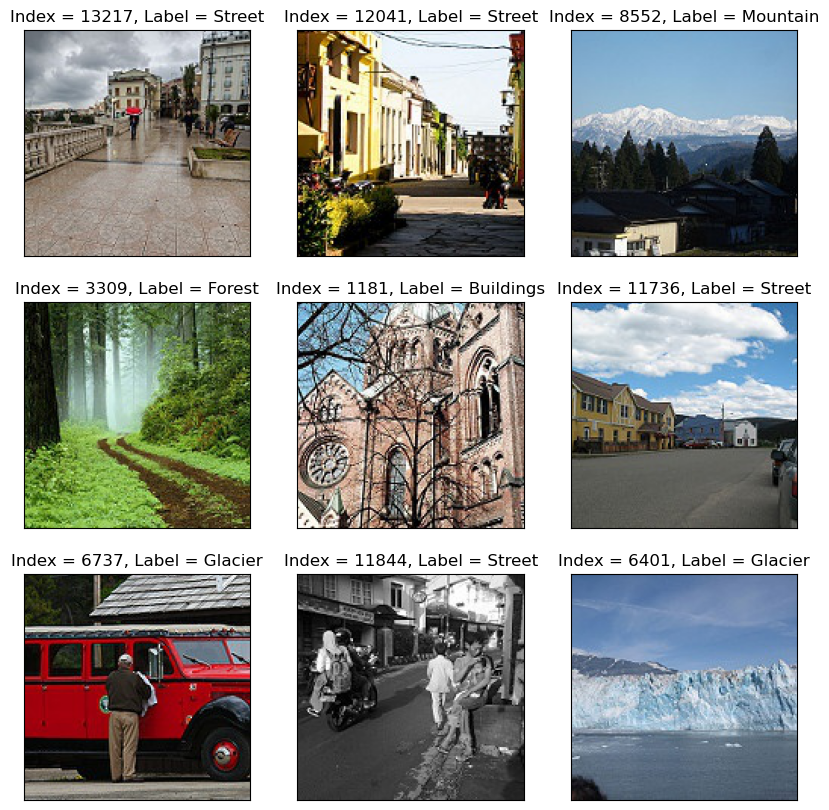

In [11]:
# Plot Data

vIdx = np.random.choice(numSamples, size = 9)
hF, vHa = plt.subplots(nrows = 3, ncols = 3, figsize = (10, 10))
vHa = vHa.flat

for ii, hA in enumerate(vHa):
    hA.imshow(dsTrain[vIdx[ii]][0].permute((1, 2, 0)).numpy())
    hA.tick_params(axis = 'both', left = False, top = False, right = False, bottom = False, 
                   labelleft = False, labeltop = False, labelright = False, labelbottom = False)
    hA.grid(False)
    hA.set_title(f'Index = {vIdx[ii]}, Label = {L_CLASSES[dsTrain[vIdx[ii]][1]]}')

plt.show()

* <font color='red'>(**?**)</font> If data is converted into _grayscale_, how would it effect the performance of the classifier? Explain.  
  You may assume the conversion is done using the mean value of the RGB pixel.

## Pre Process Data

This section:

 * Normalizes the data in a predefined manner.
 * Takes a sub set of the data.

Since the model is "borrowed" by _Transfer Learning_ one must:

1. Use the statistics from the original training set.
1. Adapt the input dimensions to match the original training set.

* <font color='brown'>(**#**)</font> The values in training are specified in documentation.  
  As an example, see [`ResNet50` Weights](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.ResNet50_Weights).

In [12]:
# The Standardization Parameters
# ImageNet statistics
vMean = np.array([0.485, 0.456, 0.406])
vStd  = np.array([0.229, 0.224, 0.225])

print('µ =', vMean)
print('σ =', vStd)

µ = [0.485 0.456 0.406]
σ = [0.229 0.224 0.225]


In [13]:
# Check Image Dimensions (Run Only Once)
# Verifies all images have the same size: 3 x 150 x 150.

# for ii in range(len(dsTrain)):
#     xx, yy = dsTrain[ii]
#     imgH = xx.shape[1]
#     imgW = xx.shape[2]
#     if ((imgH != 150) or (imgW != 150)):
#         print(f'The image {dsTrain.imgs[ii][0]} has incorrect size')

In [14]:
# Update Transforms
# Using v2 Transforms.
# Taking care of the different dimensions of some images.
# Matching the input size of ImageNet.
oDataTrnsTrain = TorchVisionTrns.Compose([
    TorchVisionTrns.ToImage(),
    TorchVisionTrns.ToDtype(torch.float32, scale = True),
    TorchVisionTrns.Resize(224),
    TorchVisionTrns.CenterCrop(224), #<! Ensures size is 150 (Pads if needed)
    ## !!!!!!!!!!!!!!!!!!!
    TorchVisionTrns.RandomHorizontalFlip(p = 0.5),
    ## !!!!!!!!!!!!!!!!!!!
    TorchVisionTrns.Normalize(mean = vMean, std = vStd),
])
oDataTrnsVal = TorchVisionTrns.Compose([
    TorchVisionTrns.ToImage(),
    TorchVisionTrns.ToDtype(torch.float32, scale = True),
    TorchVisionTrns.Resize(224),
    TorchVisionTrns.CenterCrop(224), #<! Ensures size is 150 (Pads if needed)
    TorchVisionTrns.Normalize(mean = vMean, std = vStd),
])

# Using V1
# oDataTrnsTrain = torchvision.transforms.Compose([
#     torchvision.transforms.Resize(224),
#     torchvision.transforms.CenterCrop(224),
#     torchvision.transforms.RandomHorizontalFlip(0.5),
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(mean = vMean, std = vStd),
# ])

# oDataTrnsVal = torchvision.transforms.Compose([
#     torchvision.transforms.Resize(224),
#     torchvision.transforms.CenterCrop(224),
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(mean = vMean, std = vStd),
# ])

# Update the DS transformer
dsTrain.transform   = oDataTrnsTrain
dsVal.transform     = oDataTrnsVal

* <font color='red'>(**?**)</font> What does `RandomHorizontalFlip` do? Why can it be used?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


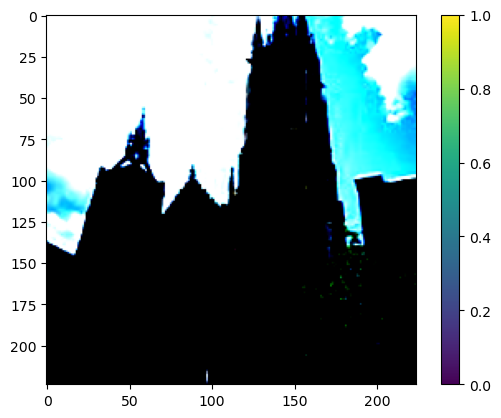

In [15]:
# "Normalized" Image

mX, valY = dsTrain[5]

hF, hA = plt.subplots()
hImg = hA.imshow(np.transpose(mX, (1, 2, 0)))
hF.colorbar(hImg)
plt.show()

* <font color='red'>(**?**)</font> How can one get the original image from `mX`?

inverse of the regulation ;

### Data Loaders

This section defines the data loaded.



In [16]:
# Data Loader

dlTrain = torch.utils.data.DataLoader(dsTrain, shuffle = True, batch_size = 1 * batchSize, num_workers = numWorkers, drop_last = True, persistent_workers = True)
dlVal   = torch.utils.data.DataLoader(dsVal, shuffle = False, batch_size = 2 * batchSize, num_workers = numWorkers, persistent_workers = True)


* <font color='blue'>(**!**)</font> Plot the histogram of labels of the data. Is it balanced?

In [17]:
# Iterate on the Loader
# The first batch.
tX, vY = next(iter(dlTrain)) #<! PyTorch Tensors

print(f'The batch features dimensions: {tX.shape}')
print(f'The batch labels dimensions: {vY.shape}')

The batch features dimensions: torch.Size([128, 3, 224, 224])
The batch labels dimensions: torch.Size([128])


In [18]:
# Looping
for ii, (tX, vY) in zip(range(1), dlVal): #<! https://stackoverflow.com/questions/36106712
    print(f'The batch features dimensions: {tX.shape}')
    print(f'The batch labels dimensions: {vY.shape}')

The batch features dimensions: torch.Size([256, 3, 224, 224])
The batch labels dimensions: torch.Size([256])


## Load the Model

This section loads the model.  
The number of outputs is adjusted to match the number of classes in the data.

In [19]:
# Loading a Pre Defined Model
oModelPreDef = GenResNetModel(trainedModel = False, numCls = len(L_CLASSES))


* <font color='blue'>(**!**)</font> Go through `GenResNetModel()`'s code.

In [20]:
# Model Information - Pre Defined
# Pay attention to the layers name.
torchinfo.summary(oModelPreDef, tX.shape, col_names = ['kernel_size', 'output_size', 'num_params'], device = 'cpu', row_settings = ['depth', 'var_names'])

Layer (type (var_name):depth-idx)             Kernel Shape              Output Shape              Param #
ResNet (ResNet)                               --                        [256, 6]                  --
├─Conv2d (conv1): 1-1                         [7, 7]                    [256, 64, 112, 112]       9,408
├─BatchNorm2d (bn1): 1-2                      --                        [256, 64, 112, 112]       128
├─ReLU (relu): 1-3                            --                        [256, 64, 112, 112]       --
├─MaxPool2d (maxpool): 1-4                    3                         [256, 64, 56, 56]         --
├─Sequential (layer1): 1-5                    --                        [256, 64, 56, 56]         --
│    └─BasicBlock (0): 2-1                    --                        [256, 64, 56, 56]         --
│    │    └─Conv2d (conv1): 3-1               [3, 3]                    [256, 64, 56, 56]         36,864
│    │    └─BatchNorm2d (bn1): 3-2            --                        [256, 

row_settings = ['depth', 'var_names']) show tha name:

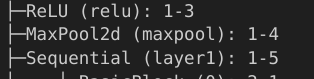

which can help do directly to layer by name:


In [31]:
oModelPreDef.maxpool

MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

In [33]:
list(oModelPreDef.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [34]:
len(list(oModelPreDef.children()))

10

In [36]:
len(list(oModelPreDef.modules()))

68

* <font color='red'>(**?**)</font> Which layer should be adapted?


changed only the FC;


* <font color='red'>(**?**)</font> Does the last (_Head_) dense layer includes a bias? Explain.


```
├─AdaptiveAvgPool2d (avgpool): 1-9            --                        [256, 512, 1, 1]          --
├─Linear (fc): 1-10                           --                        [256, 6]                  3,078

512 * 6 =  3072 + 6 = 3078 ; include bias

```

In [22]:
# Model Information - Pre Trained
# Pay attention to the layers name.
oModelPreTrn = GenResNetModel(trainedModel = True, numCls = len(L_CLASSES))

In [23]:
# Model Information
# Pay attention to the variable name
torchinfo.summary(oModelPreTrn, tX.shape, col_names = ['kernel_size', 'output_size', 'num_params'], device = 'cpu', row_settings = ['depth', 'var_names'])

Layer (type (var_name):depth-idx)             Kernel Shape              Output Shape              Param #
ResNet (ResNet)                               --                        [256, 6]                  --
├─Conv2d (conv1): 1-1                         [7, 7]                    [256, 64, 112, 112]       9,408
├─BatchNorm2d (bn1): 1-2                      --                        [256, 64, 112, 112]       128
├─ReLU (relu): 1-3                            --                        [256, 64, 112, 112]       --
├─MaxPool2d (maxpool): 1-4                    3                         [256, 64, 56, 56]         --
├─Sequential (layer1): 1-5                    --                        [256, 64, 56, 56]         --
│    └─BasicBlock (0): 2-1                    --                        [256, 64, 56, 56]         --
│    │    └─Conv2d (conv1): 3-1               [3, 3]                    [256, 64, 56, 56]         36,864
│    │    └─BatchNorm2d (bn1): 3-2            --                        [256, 

re train change our last layer to:


```
├─Sequential (fc): 1-10                       --                        [256, 6]                  --
│    └─Linear (0): 2-9                        --                        [256, 128]                65,664
│    └─ReLU (1): 2-10                         --                        [256, 128]                --
│    └─Linear (2): 2-11   
```

## Train the Model

This section trains the model.  
It compares pre trained model with pre defined model using the same number of epochs.


### Transfer Learning Fine Tuning

The training of the model on the new data is often called _fine tuning_ (See [Fine Tuning vs. Transfer Learning vs. Learning from Scratch](https://stats.stackexchange.com/questions/343763) for a discussion on the semantic).  
The concept is training the new layers of the model with the new data while keeping most of the "knowledge" of the model from its original training.  
The balance is done by the adaptation of the learning per layer with the extreme of zero learning rate for some layers (Freezing).  
The most used combinations are:

 - Freeze Layers  
   Freeze (Zero learning rate) the pre trained layers by disabling the gradient (`requires_grad`).
 - Smaller Learning Rate  
   Set a smaller learning rate to the pre trained layers.
 - Small Learning  
   Use small learning rate to the whole process.

In some cases, the policy used is a combination of 2 (Freeze at the beginning / end, the release, etc..).

* <font color='brown'>(**#**)</font> Freezing is also a regularization as its assists in preventing _over fitting_.
* <font color='brown'>(**#**)</font> [PyTorch Optimizer - Per Parameter Learning Rate](https://pytorch.org/docs/stable/optim.html#per-parameter-options).
* <font color='brown'>(**#**)</font> See [Dive into Deep Learning - Computer Vision - Fine Tuning](http://d2l.ai/chapter_computer-vision/fine-tuning.html).
* <font color='brown'>(**#**)</font> Guide to Fine Tuning in PyTorch: [Part I](https://scribe.rip/8990194b71e), [Part II](https://scribe.rip/b0f8f447546b).
* <font color='brown'>(**#**)</font> [How to Freeze Model Weights in PyTorch for Transfer Learning: Step by Step Tutorial](https://scribe.rip/a533a58051ef).

In [24]:
# Freeze Layers
# Iterating over the net, see https://stackoverflow.com/questions/54203451

for paramName, oPrm in oModelPreTrn.named_parameters():
    if not ('fc' in paramName):
        oPrm.requires_grad = False

* <font color='blue'>(**!**)</font> Exclude _Batch Norm_ layers as well.

In [25]:
# Run Device

runDevice = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #<! The 1st CUDA device


In [26]:
# Models

lModel = [('Pre Defined Model', oModelPreDef), ('Pre Trained Model', oModelPreTrn)]


In [27]:
# Loss and Score Function

hL = nn.CrossEntropyLoss()
hS = MulticlassAccuracy(num_classes = len(lClass), average = 'micro')
hL = hL.to(runDevice) #<! Not required!
hS = hS.to(runDevice)

* <font color='brown'>(**#**)</font> The averaging mode `macro` averages samples per class and average the result of each class.
* <font color='brown'>(**#**)</font> The averaging mode `micro` averages all samples.
* <font color='red'>(**?**)</font> Check results with `average = 'micro'`. Explain how `shuffle - False` in the validation data loader affects the results.

### parameters

In [41]:
list(oModelPreTrn.parameters())



[Parameter containing:
 tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
             1.7083e-02, -1.2694e-02],
           [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
            -1.2907e-01,  3.7424e-03],
           [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
             2.5632e-01,  6.3573e-02],
           ...,
           [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
            -4.2058e-01, -2.5781e-01],
           [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
             3.9359e-01,  1.6606e-01],
           [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
            -8.2230e-02, -5.7828e-03]],
 
          [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
             6.6221e-04, -2.5743e-02],
           [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
            -1.6051e-01, -1.2826e-03],
           [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
             3.6

In [42]:
len(list(oModelPreTrn.parameters()))



64

In [44]:
(list(oModelPreTrn.fc.parameters()))


[Parameter containing:
 tensor([[ 0.0345, -0.3183, -0.4702,  ...,  0.0426, -0.2295,  0.1899],
         [-0.0395, -0.0307,  0.0222,  ..., -0.0358,  0.0175, -0.0546],
         [ 0.0213,  0.0333,  0.0223,  ..., -0.0761,  0.0598, -0.0121],
         ...,
         [ 0.0981, -0.0773,  0.0473,  ...,  0.0361, -0.0102, -0.0076],
         [-0.0779, -0.0764, -0.1302,  ...,  0.0722, -0.0760, -0.0214],
         [-0.0006, -0.0591, -0.1613,  ..., -0.0418,  0.0960, -0.0646]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 2.3882e-02,  2.3160e-02,  1.0865e-02, -9.5149e-02,  2.0054e-02,
         -2.8129e-02, -8.1836e-02, -4.5059e-02, -3.3202e-02, -5.0288e-02,
          1.5722e-02, -8.1809e-02,  3.8963e-02,  2.1192e-02,  1.5252e-02,
          1.8656e-02,  2.2183e-02, -8.6538e-02, -1.8721e-02, -2.0963e-02,
          2.8428e-02, -9.9596e-03, -1.4719e-02, -3.3502e-02, -3.6034e-02,
          2.7984e-02, -4.0156e-02,  1.6873e-03, -7.8723e-03,  1.3919e-01,
         -4.9428e-02,  

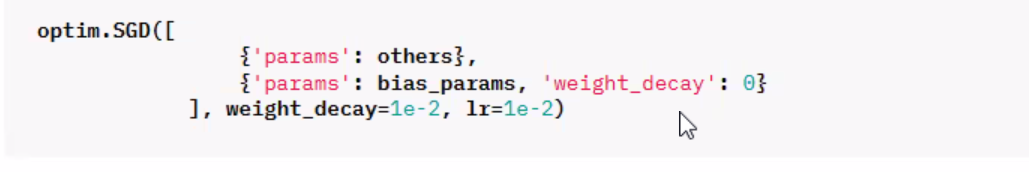

In [29]:
# Training Loop

dModelHist = {}

for ii, (modelName, oModel) in enumerate(lModel):
    print(f'Training with the {modelName} model')
    oModel = oModel.to(runDevice) #<! Transfer model to device
    oOpt = torch.optim.AdamW(oModel.parameters(), lr = 1e-4, betas = (0.9, 0.99), weight_decay = 2e-4) #<! Define optimizer
    oSch = torch.optim.lr_scheduler.OneCycleLR(oOpt, max_lr = 2e-2, total_steps = numEpochs * len(dlTrain))
    _, lTrainLoss, lTrainScore, lValLoss, lValScore, lLearnRate = TrainModelSch(oModel, dlTrain, dlVal, oOpt, oSch, numEpochs, hL, hS)
    dModelHist[modelName] = lTrainLoss, lTrainScore, lValLoss, lValScore, lLearnRate

Training with the Pre Defined Model model
Epoch    1 / 10 | Train Loss:  0.880 | Val Loss:  1.544 | Train Score:  0.662 | Val Score:  0.541 | Epoch Time: 87.48 | <-- Checkpoint! |
Epoch    2 / 10 | Train Loss:  0.798 | Val Loss:  1.403 | Train Score:  0.713 | Val Score:  0.547 | Epoch Time: 62.12 | <-- Checkpoint! |
Epoch    3 / 10 | Train Loss:  0.677 | Val Loss:  2.505 | Train Score:  0.755 | Val Score:  0.453 | Epoch Time: 61.74 |
Epoch    4 / 10 | Train Loss:  0.609 | Val Loss:  0.877 | Train Score:  0.782 | Val Score:  0.671 | Epoch Time: 61.84 | <-- Checkpoint! |
Epoch    5 / 10 | Train Loss:  0.516 | Val Loss:  0.684 | Train Score:  0.817 | Val Score:  0.742 | Epoch Time: 61.69 | <-- Checkpoint! |
Epoch    6 / 10 | Train Loss:  0.442 | Val Loss:  0.510 | Train Score:  0.841 | Val Score:  0.816 | Epoch Time: 61.84 | <-- Checkpoint! |
Epoch    7 / 10 | Train Loss:  0.382 | Val Loss:  0.607 | Train Score:  0.866 | Val Score:  0.793 | Epoch Time: 61.62 |
Epoch    8 / 10 | Train Loss

* <font color='green'>(**@**)</font> Add _TensorBoard_ based monitoring. You should use the `TBLogger` class.
* <font color='red'>(**?**)</font> Compare run time and memory consumption during the training of the models. How can it be utilized?

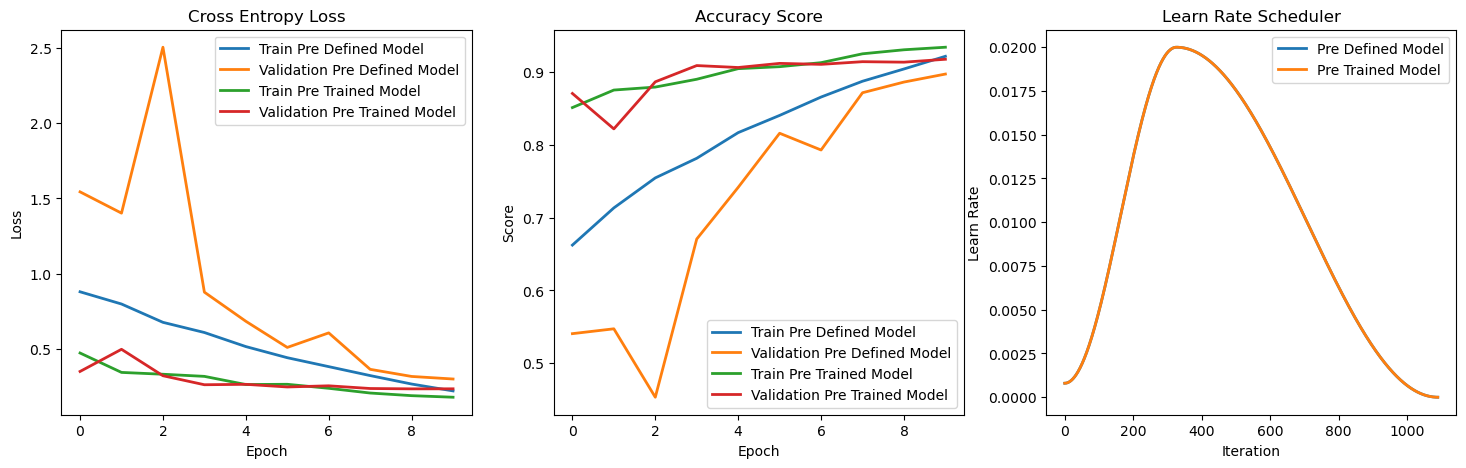

In [30]:
# Plot Training Phase

hF, vHa = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 5))
vHa = np.ravel(vHa)

for modelKey in dModelHist:
    hA = vHa[0]
    hA.plot(dModelHist[modelKey][0], lw = 2, label = f'Train {modelKey}')
    hA.plot(dModelHist[modelKey][2], lw = 2, label = f'Validation {modelKey}')
    hA.set_title('Cross Entropy Loss')
    hA.set_xlabel('Epoch')
    hA.set_ylabel('Loss')
    hA.legend()

    hA = vHa[1]
    hA.plot(dModelHist[modelKey][1], lw = 2, label = f'Train {modelKey}')
    hA.plot(dModelHist[modelKey][3], lw = 2, label = f'Validation {modelKey}')
    hA.set_title('Accuracy Score')
    hA.set_xlabel('Epoch')
    hA.set_ylabel('Score')
    hA.legend()

    hA = vHa[2]
    hA.plot(lLearnRate, lw = 2, label = f'{modelKey}')
    hA.set_title('Learn Rate Scheduler')
    hA.set_xlabel('Iteration')
    hA.set_ylabel('Learn Rate')
    hA.legend()

* <font color='green'>(**@**)</font> Build the `Test` data loader (You may use `dsTest`) and exam the models on few samples.
* <font color='green'>(**@**)</font> Redo the training with a different model.
* <font color='red'>(**?**)</font> Look at the [`Places365`](http://places.csail.mit.edu/) ([`Places365 v2`](http://places2.csail.mit.edu/)) data set.  
  If the base model for transfer learning is trained on `Places365`, what effect will it have on the results?  
  Think of the type of the task. You may try it with [`Release of Places365-CNNs`](https://github.com/CSAILVision/places365).